# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, а также контролировать добросовестность кассиров при продаже алкоголя

---
**Цель исследования:** построить модель, которая по фотографии определит приблизительный возраст человека

---

**План выполнения работы:**

<br> 

- загрузка и предварительное изучение данных
- предобработка табличных данных
- исследовательский анализ данных
- обучение модели компьютерного зрения в GPU-тренажёре
- анализ результата
    
Каждый шаг исследования заканчивается промежуточным выводом. В конце исследования даётся общий подробный вывод

---

- в распоряжении имеются таблица с наименованиями размеченных по возрасту фотографий и папка с этими изображениями
- итоговая метрика MAE получившейся модели должна быть не меньше 8

---

In [1]:
# установка широкоформатного jupyter

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# импорт библиотек

import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [3]:
# константы

RANDOM_STATE = 42

IMAGES_PATH = '/datasets/faces/final_files/'
CSV_PATH = '/datasets/faces/labels.csv'

---

In [4]:
def get_info(data):
    
    """
    Функция get_info выводит на экран пять случайных строк таблицы и общую информацию, полученную с помощью info()

    Аргументы:
    data (DataFrame): датафрейм

    """
    
    print('Пять случайных строк таблицы:')
    display(data.sample(5))
    print(' ')
    print('Общая информация о таблице:')
    print(' ')
    print(data.info())

In [5]:
def preprocess(data, data_name):
    
    """
    Функция preprocess выводит на экран количество дубликатов и пропусков в датафрейме

    Аргументы:
    data (DataFrame) : датафрейм
    data_name (str) : название датафрейма
    
    """
    
    for col in data:
        isna_count = data[col].isna().sum()
        if isna_count > 0:
            print(f'Пропусков найдено в столбце {col}: {isna_count}')
    isna_total = data.isna().sum().sum()
    if isna_total == 0:
        print(f'В таблице {data_name} не найдено ни одного пропуска!')
        
    duplicates_count = data.duplicated().sum()
    if duplicates_count > 0:
        print(f'Дубликатов найдено: {duplicates_count}')
    else:
        print(f'В таблице {data_name} не найдено ни одного дубликата!')

In [6]:
def describe(data, col, data_name):
                    
    """
    Функция describe выводит на экран числовое описание данных в количественном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Числовое описание столбца {col} таблицы {data_name}:')
    print(' ')
    print(data[col].describe())

In [7]:
def value_counts(data, col, data_name):
                
    """
    Функция value_counts выводит на экран числовое распределение данных в категориальном столбце

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    data_name (str) : название датафрейма
    
    """
    
    print(f'Распределение данных в столбце {col} таблицы {data_name}:')
    print(' ')
    print(data[col].value_counts())

In [8]:
def hist_violin(data, col, bins, title, xlabel):
                        
    """
    Функция hist_violin выводит на экран гистограмму и скрипичную диаграмму для количественного столбца датафрейма

    Аргументы:
    data (DataFrame) : датафрейм
    col (str) : столбец датафрейма
    bins (int) : количество корзин для построения гистограммы
    title (str) : название графика
    xlabel (str) : подпись оси X у обоих графиков
    
    """
    
    sns.set(style='darkgrid', palette='pastel')
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    
    sns.histplot(data=data, x=col, kde=True, bins=bins, color='indianred')
    plt.title('Гистограмма')
    plt.ylabel('Количество наблюдений')
    plt.xlabel(xlabel)
    ax[0].grid()
    
    sns.violinplot(x=data[col], ax=ax[0], color='skyblue')
    ax[0].set_title('Скрипичная диаграмма')
    ax[0].set_ylabel('Значения')
    ax[0].set_xlabel(xlabel)
    ax[0].grid()
    
    ax_title = fig.add_axes([0.5, 1.0, 0.1, 0.1])
    ax_title.set_axis_off()
    ax_title.text(0, 0, title, ha='center', va='center', fontsize=16)

    plt.show()

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Загрузка, предварительное изучение и предобработка данных
</div>

---

In [9]:
# загрузим csv-файл

labels = pd.read_csv(CSV_PATH)

In [10]:
# выведем на экран общую информацию о таблице

get_info(labels)

Пять случайных строк таблицы:


,file_name,real_age
3047,003047.jpg,14
3214,003214.jpg,54
5767,005767.jpg,33
5565,005565.jpg,25
2016,002016.jpg,58


 
Общая информация о таблице:
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


- таблица `labels` содержит 7591 наблюдение
- типы данных определены верно
- описание данных соответствует реальности

In [11]:
# проверим таблицу на наличие пропусков и дубликатов

preprocess(labels, 'labels')

В таблице labels не найдено ни одного пропуска!
В таблице labels не найдено ни одного дубликата!


In [12]:
# загрузим изображения

datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = IMAGES_PATH,
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = 'raw',
        seed=RANDOM_STATE)

Found 7591 validated image filenames.


In [13]:
# извлечём изображения и их метки

features, target = next(train_gen_flow)

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Исследовательский анализ данных
</div>

---

In [14]:
# посмотрим на числовое описание столбца real_age

describe(labels, 'real_age', 'labels')

Числовое описание столбца real_age таблицы labels:
 
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


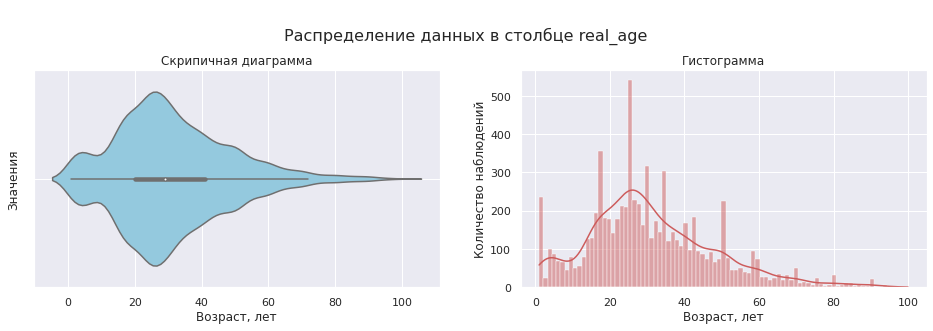

In [15]:
# выведем на экран скрипичную диаграмму и гистограмму для столбца real_age

hist_violin(labels, 'real_age', 87, 'Распределение данных в столбце real_age', 'Возраст, лет')

In [16]:
# сохраним срез данных по возрасту до 15 и от 75 лет в соответствующие переменные

under_15 = labels.query('real_age < 15')
above_75 = labels.query('real_age > 75')

In [17]:
# посмотрим, сколько наблюдений есть для категорий возраста до 15 лет

value_counts(under_15, 'real_age', 'under_15')

Распределение данных в столбце real_age таблицы under_15:
 
1     149
14    125
4     101
2      88
5      87
13     79
6      68
7      67
12     56
11     51
10     45
8      44
9      34
3      25
Name: real_age, dtype: int64


In [18]:
# теперь посмотрим количество наблюдений для возрастной группы от 75 лет

value_counts(above_75, 'real_age', 'above_75')

Распределение данных в столбце real_age таблицы above_75:
 
80     31
90     21
85     12
84      8
77      8
76      7
87      6
79      6
82      5
94      5
89      4
83      3
81      3
86      3
88      3
78      3
95      2
96      2
91      1
93      1
97      1
100     1
Name: real_age, dtype: int64


<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

Средний возраст людей, чьи фотографии находятся в данных, составил 31 год, по медиане — 29. В данных отображены люди возрастом от 1 до 100 лет, при этом на 75% фотографий изображены люди, чей возраст ниже или равен 41 году

На обоих графиках мы видим небольшой всплеск значений на отметке в 4-5 лет, основное же количество данных сосредоточено в диапазоне от 15 до 60 лет. Внимательно рассмотрев распределение в срезе данных до 15 лет по левому краю и от 75 лет по правому краю, можно заметить, что данных об очень молодых и о пожилых людях крайне мало. Модель вряд ли сможет корректно обучиться определять 97-летний или 100-летний возраст человека по 1-2 фотографиям. Также в данных вовсе отсутстуют фотографии людей, чей возраст составляет 92 года или 98 лет

Уже на этом этапе можно сделать вывод, что модель будет очень плохо справляться с краевыми значениями по обе стороны. Необходимо либо выбрать другой датасет или существенно дополнить текущий, либо вовсе избавиться от плохо отображённых возрастов
    
</div>

In [19]:
# посмотрим на значения пикселей изображения из первого батча тренировочной выборки

for image_batch, label_batch in train_gen_flow:
    first_image = image_batch[0]
    print(first_image)
    break

[[[0.37254903 0.37254903 0.37254903]
  [0.37254903 0.37254903 0.37254903]
  [0.37254903 0.37254903 0.37254903]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.37647063 0.37647063 0.37647063]
  [0.37647063 0.37647063 0.37647063]
  [0.37254903 0.37254903 0.37254903]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.36862746 0.36862746 0.36862746]
  [0.36862746 0.36862746 0.36862746]
  [0.37254903 0.37254903 0.37254903]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.16862746 0.1764706  0.23529413]
  [0.1764706  0.18431373 0.24313727]
  [0.16862746 0.1764706  0.23529413]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.15686275 0.17254902 0.21960786]
  [0.16470589 0.18039216 0.227451  ]


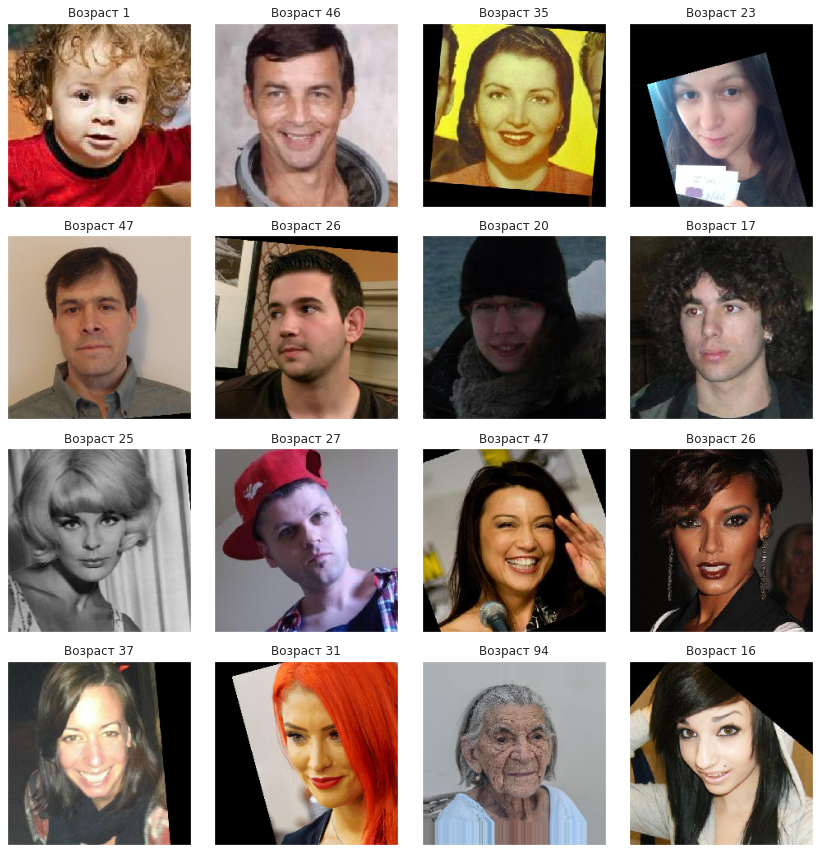

In [20]:
# посмотрим на 16 примеров картинок

fig = plt.figure(figsize=(12, 12))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title( f'Возраст {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div style="border: 1px solid rgba(0, 0, 0, 0.2); border-radius: 10px; background-color: rgba(255, 255, 255, 0.8); padding: 10px;">

На приведённых выше примерах фотографий мы видим, что на всех них абсолютно разный поворот головы, разное направление взгляда, разное освещение (фотографии могут содержать как сильный пересвет, так и затемнение). Также на этих фотографиях мы видим яркие элементы, аксессуары, частичные изображения лиц других людей и различные предметы, что может также помешать модели хорошо обучиться
    
</div>

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Обучение модели
</div>

---

Ниже приведён код обучения модели и результат её вывода (код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
		
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
	
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
			  
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-04-04 21:06:52.825972: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-04 21:06:53.135185: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 49s - loss: 191.0146 - mae: 10.3433 - val_loss: 417.7920 - val_mae: 15.4153
Epoch 2/10
178/178 - 40s - loss: 99.4336 - mae: 7.5143 - val_loss: 424.8357 - val_mae: 15.5443
Epoch 3/10
178/178 - 39s - loss: 64.3117 - mae: 6.1300 - val_loss: 330.3944 - val_mae: 13.4582
Epoch 4/10
178/178 - 39s - loss: 43.1193 - mae: 5.0707 - val_loss: 177.1390 - val_mae: 10.1197
Epoch 5/10
178/178 - 39s - loss: 30.1227 - mae: 4.2345 - val_loss: 98.3517 - val_mae: 7.4262
Epoch 6/10
178/178 - 39s - loss: 21.2552 - mae: 3.5402 - val_loss: 86.4077 - val_mae: 7.1001
Epoch 7/10
178/178 - 40s - loss: 14.9509 - mae: 3.0214 - val_loss: 74.3253 - val_mae: 6.4831
Epoch 8/10
178/178 - 40s - loss: 10.1274 - mae: 2.4661 - val_loss: 82.1129 - val_mae: 6.6323
Epoch 9/10
178/178 - 39s - loss: 8.8343 - mae: 2.2840 - val_loss: 75.0067 - val_mae: 6.4495
Epoch 10/10
178/178 - 39s - loss: 8.1564 - mae: 2.1792 - val_loss: 72.8348 - val_mae: 6.2682
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 72.8348 - mae: 6.2682
Test MAE: 6.2682
```

---

<div style="background-color: rgba(255, 255, 255, 0.8); padding: 20px; font-size: 25px; color: rgba(28, 28, 28, 1);">
Анализ обученной модели
</div>

---

Была успешно обучена нейросеть, распознающая возраст людей по их фотографии:

- функция `load_train` загружает данные для обучения с горизонтальным отражением в качестве аугментации, размер изображений устанавливается равным 224x224, также к изображениям применяется масштабирование


- функция `load_test` аналогична `load_train`, но загружает данные для тестирования и разделяет данные без использования аугментации


- функция `create_model` создает модель нейронной сети на основе архитектуры ResNet50 с обученными весами на ImageNet. Модель представляет из себя ResNet50 без верхних слоев, затем слой GlobalAveragePooling2D для усреднения признаков и один полносвязанный слой с одним нейроном, который использует функцию активации ReLU. Дополнительные слои необходимы для задачи регресии


- для оптимизации используется алгоритм Adam с коэффициентом скорости обучения 0.0005, в качестве функции потерь — `mean_squared_error`, в качестве метрики — `MAE` (средняя абсолютная ошибка)


- итоговая метрика `MAE` равна 6.2682, что полностью соответствует условию задачи

---